In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import time
import numpy as np
import pandas as pd

# BESOS
from besos import eppy_funcs as ef
from besos import sampling
from besos.evaluator import EvaluatorEP, EvaluatorGeneric
from besos.parameters import (
    Parameter,
    RangeParameter,
    FieldSelector,
    expand_plist,
    wwr,
    CategoryParameter,
    GenericSelector
)
from besos.problem import EPProblem, Problem
from besos.optimizer import NSGAII

# Visualización
import matplotlib.pyplot as plt
from seaborn import heatmap, pairplot
from plotly import express as px

# Scikit-learn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import warnings

from epw import epw

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
building = ef.get_building("office.idf")
epw_file='Larnaca_Larnax_Airp_-hour.epw'

In [3]:
meteo = epw()
meteo.read(epw_file)
meteo.dataframe.describe()

,Year,Month,Day,Hour,Minute,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Atmospheric Station Pressure,Extraterrestrial Horizontal Radiation,...,Ceiling Height,Present Weather Observation,Present Weather Codes,Precipitable Water,Aerosol Optical Depth,Snow Depth,Days Since Last Snowfall,Albedo,Liquid Precipitation Depth,Liquid Precipitation Quantity
count,8760.0,8760.000000,8760.000000,8760.000000,8760.0,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,...,8760.0,8760.0,8760.0,8760.000000,8760.000000,8760.0,8760.000000,8.760000e+03,8760.000000,8760.0
mean,2005.0,6.526027,15.720548,12.500000,60.0,20.339623,13.321301,66.312557,101277.640982,348.568493,...,99999.0,9.0,999999999.0,25.495662,0.174258,0.0,74.213014,2.000000e-01,0.037705,99.0
std,0.0,3.448048,8.796749,6.922582,0.0,7.095390,5.653212,16.089700,188.766190,434.018625,...,0.0,0.0,0.0,10.274516,0.060578,0.0,26.073199,2.775716e-17,0.375435,0.0
min,2005.0,1.000000,1.000000,1.000000,60.0,2.600000,-1.600000,30.000000,100507.000000,0.000000,...,99999.0,9.0,999999999.0,8.000000,0.039000,0.0,0.000000,2.000000e-01,0.000000,99.0
25%,2005.0,4.000000,8.000000,6.750000,60.0,14.800000,8.800000,53.000000,101173.000000,0.000000,...,99999.0,9.0,999999999.0,17.000000,0.126000,0.0,76.000000,2.000000e-01,0.000000,99.0
50%,2005.0,7.000000,16.000000,12.500000,60.0,20.200000,12.700000,67.000000,101315.000000,18.000000,...,99999.0,9.0,999999999.0,23.000000,0.181000,0.0,88.000000,2.000000e-01,0.000000,99.0
75%,2005.0,10.000000,23.000000,18.250000,60.0,25.800000,18.100000,80.000000,101407.000000,726.000000,...,99999.0,9.0,999999999.0,33.000000,0.218000,0.0,88.000000,2.000000e-01,0.000000,99.0
max,2005.0,12.000000,31.000000,24.000000,60.0,38.400000,27.200000,100.000000,101700.000000,1294.000000,...,99999.0,9.0,999999999.0,62.000000,0.338000,0.0,88.000000,2.000000e-01,14.200000,99.0


In [4]:
roof_ins = FieldSelector(class_name='Material',
                         object_name='_InsulationEX_Roof_.01',
                         field_name='Thickness')
wall_ins = FieldSelector(class_name='Material', 
                         object_name='_InsulationEX_.01', 
                         field_name='Thickness')

wall_range = RangeParameter(min_val=0.1,max_val=0.5)
roof_range = RangeParameter(min_val=0.1,max_val=0.8)

insulation_param = [Parameter(selector=wall_ins,
                                 value_descriptor=wall_range ,
                                 name='Wall Insulation'),
                   Parameter(selector=roof_ins,
                                 value_descriptor=roof_range ,
                                 name='Roof Insulation')]

In [5]:
ventAchRange = RangeParameter(min_val = 0.0, max_val=6.0)

ventilationAchParam = []


ventACH_sel = FieldSelector(class_name = 'ZoneVentilation:DesignFlowRate', 
                    object_name = '*', 
                    field_name = 'Air Changes per Hour')
ventilationAchParam.append(Parameter(selector=ventACH_sel, 
                                     value_descriptors=ventAchRange, 
                                     name='Ventilation ACH'))

In [6]:
lights_selector = FieldSelector(class_name='Lights', object_name='*', field_name='Watts per Zone Floor Area')
lights_range = RangeParameter(min_val=5,max_val=20)

lights_param =     Parameter(
        lights_selector,
        value_descriptor=lights_range ,
        name="Lights Watts/Area",
    )

In [7]:
TempShadingRange = RangeParameter(min_val = 18, max_val=30)
RadShadingRange = RangeParameter(min_val = 30, max_val=300)

setpointParams = []
shade_setpoint_sel = FieldSelector(class_name ='WindowShadingControl', 
                    object_name = '*', 
                    field_name='Setpoint' )
shade_setpoint2_sel = FieldSelector(class_name ='WindowShadingControl', 
                     object_name = '*', 
                     field_name='Setpoint 2' )
setpointParams.append(Parameter(selector=shade_setpoint_sel, value_descriptor = TempShadingRange, name='Temp Setpoint shading'))
setpointParams.append(Parameter(selector=shade_setpoint2_sel, value_descriptor = RadShadingRange, name='Rad Setpoint shading'))

In [8]:
parameters = insulation_param + ventilationAchParam + [lights_param] + setpointParams

In [9]:
objectives = ['Electricity:Facility','DistrictHeating:Facility','DistrictCooling:Facility'] # these get made into `MeterReader` or `VariableReader`

problem=EPProblem(parameters, objectives) # problem = parameters + objectives

problem.names()

['Wall Insulation',
 'Roof Insulation',
 'Ventilation ACH',
 'Lights Watts/Area',
 'Temp Setpoint shading',
 'Rad Setpoint shading',
 'Electricity:Facility',
 'DistrictHeating:Facility',
 'DistrictCooling:Facility']

In [10]:
evaluator = EvaluatorEP(problem, 
                        building, 
                        out_dir='outputdir', 
                        err_dir='outputdir',
                        epw_file=epw_file,
                        progress_bar=True)

In [11]:
initial_points_df = sampling.dist_sampler(sampling.lhs, problem, num_samples=20) #Creates 20 samples to be evaluated with EnergyPlus, these are going to
#be te 20 initial points for the FuzzyLolaVoronoi sampler from Harlow

In [12]:
t1 = time.time()
# Run Energyplus
initial_samples = evaluator.df_apply(initial_points_df,
                             keep_input=True, 
                             #keep_dirs=True, 
                             processes=1)  # flag keep_dirs to True to save all ouput
t2 = time.time()
time_of_sim = t2 - t1

Executing:   0%|          | 0/20 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running Ener

In [13]:
#here we obtain the time it took to simulate all the samples

def niceformat(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    return hour, minutes, seconds


hours, mins, secs = niceformat(time_of_sim)

print(
    "The total running time: {:2.0f} hours {:2.0f} min {:2.0f} seconds".format(
        hours, mins, secs
    )
)

The total running time:  0 hours  3 min 32 seconds


In [14]:
initial_samples.to_pickle("simulation_initial_points_example_7_20.pkl")

input_cols = [
    "Wall Insulation", "Roof Insulation", "Lights Watts/Area",
    "Ventilation ACH", "Temp Setpoint shading", "Rad Setpoint shading"
]


output_cols = [
    "Electricity:Facility", "DistrictHeating:Facility", "DistrictCooling:Facility"
]

In [15]:
initial_points_x = initial_samples[input_cols].values.astype(float)  
initial_points_y = initial_samples[output_cols].values.astype(float)  

In [16]:
test_points_df = sampling.dist_sampler(sampling.lhs, problem, num_samples=5) 

In [17]:
t1 = time.time()
# Run Energyplus
test_samples = evaluator.df_apply(test_points_df,
                             keep_input=True, 
                             #keep_dirs=True, 
                             processes=1)  # flag keep_dirs to True to save all ouput
t2 = time.time()
time_of_sim = t2 - t1

Executing:   0%|          | 0/5 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...


In [18]:
#here we obtain the time it took to simulate all the samples

def niceformat(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    return hour, minutes, seconds


hours, mins, secs = niceformat(time_of_sim)

print(
    "The total running time: {:2.0f} hours {:2.0f} min {:2.0f} seconds".format(
        hours, mins, secs
    )
)

The total running time:  0 hours  0 min 53 seconds


In [19]:
test_samples.to_pickle("simulation_test_points_example_7_5.pkl")

test_x = test_samples[input_cols].values.astype(float)
test_y = test_samples[output_cols].values.astype(float)

In [20]:
#this is the first scaling, this is needed in order for harlow to work

scaler = StandardScaler()
initial_points_x_scale = scaler.fit_transform(X=initial_points_x)
test_x_scale = scaler.transform(X=test_x)

scaler_out = StandardScaler()
initial_points_y_scale = scaler_out.fit_transform(X=initial_points_y)
test_y_scale = scaler_out.transform(X=test_y)

In [21]:
# this are the bounds for harlow, please verify that are the same and in the same order as the parameters you created with besos
import numpy as np

# Bounds originales
domain_lower_bound = np.array([0.1,  0.1, 0.0,  5, 18,  80], dtype=float)
domain_upper_bound = np.array([0.5,  0.8, 6.0, 20, 30, 300], dtype=float)

# Scaling bounds is also necessary, use the same scaler that you used for the inputs in tis case "scaler"
scaled_lower_bound = scaler.transform(domain_lower_bound.reshape(1, -1)).ravel()
scaled_upper_bound = scaler.transform(domain_upper_bound.reshape(1, -1)).ravel()

print("Scaled lower bounds:", scaled_lower_bound)
print("Scaled upper bounds:", scaled_upper_bound)

Scaled lower bounds: [-1.72420748 -1.69069702 -2.89076017  1.15262074 -1.73666041 -1.0751169 ]
Scaled upper bounds: [ 1.70952916  1.68727737 -1.50059497  9.83202527  1.75807006  1.68843654]


In [22]:
input_cols  = list(initial_points_x.columns)  if hasattr(initial_points_x, 'columns')  else [f'x{i}' for i in range(initial_points_x.shape[1])]
output_cols = list(initial_points_y.columns)  if hasattr(initial_points_y, 'columns') else ['Electricity:Facility','DistrictHeating:Facility','DistrictCooling:Facility']

def target_f(x):
    """
    This function is the most important part when coupling EnergyPlus besos evaluator for it to work with harlow, this takes the new point 
    generated by harlow each adaptive iteration, descales it, reshapes it to the form the evaluator need it in order to work, then the evaluation is
    done and the output is again scaled and returned in order for harlow to work, please use the same scalers.
    """
    # 1) Reshape to a numpy 2D
    x_arr = np.array(x, dtype=float)
    if x_arr.ndim == 1:
        x_arr = x_arr.reshape(1, -1)

    # 2) Descaling to original values
    x_orig = scaler.inverse_transform(x_arr)

    # 3) evaluates next point with BESOS/EPEvaluator
    df_in = pd.DataFrame(x_orig, columns=input_cols)
    df_out = evaluator.df_apply(df_in)
    y_orig = df_out[output_cols].values.astype(float)

    # 4) Scaling the output again for harlow
    y_scaled = scaler_out.transform(y_orig)

    return y_scaled

In [23]:
#necessary inputs from harlow for this example we will employ 
#LolaVoronoi sampler
#BatchIndependentGaussianProcess surrogate for estimating loss and new better points

import os
import numpy as np
from harlow.surrogating.surrogate_model import BatchIndependentGaussianProcess
from harlow.sampling import FuzzyLolaVoronoi

# Defining a custom RMSE for multi output, used for stopping criteria
def rmse_multi(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    return np.sqrt(np.mean((y_true - y_pred)**2))

surrogate_model = BatchIndependentGaussianProcess

# Initializing the adaptive sampler
adaptive_samples = FuzzyLolaVoronoi(
    target_function    = target_f,
    surrogate_model    = surrogate_model,
    domain_lower_bound = scaled_lower_bound,
    domain_upper_bound = scaled_upper_bound,
    fit_points_x       = initial_points_x_scale,
    fit_points_y       = initial_points_y_scale,
    test_points_x      = test_x_scale,
    test_points_y      = test_y_scale,
    evaluation_metric  = rmse_multi
)

# patch for obtaining a 2D array
_orig_update = adaptive_samples.surrogate_model.update

def _update_force2d(X, y, **kwargs):
    y_arr = np.array(y, dtype=float)
    if y_arr.ndim == 1:
        y_arr = y_arr.reshape(1, -1)
    return _orig_update(X, y_arr, **kwargs)
adaptive_samples.surrogate_model.update = _update_force2d

# Executes adaptive sampling
adaptive_samples.sample(
    n_initial_points           = initial_points_x.shape[0],
    max_n_iterations           = 10,
    n_new_points_per_iteration = 1,
    stopping_criterium         = [0.01]
)




Iter = 99 / 100, Loss = 0.3840447664260864, Loss_ratio = Nonee

2025-05-26 18:31:37.942 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:126 - Fitted the first surrogate model in 0.3348383903503418 sec.
2025-05-26 18:31:37.952 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 1 (max steps: 10).


Iter = 100, Loss = 0.3840447664260864, Loss_ratio = None


2025-05-26 18:31:38.184 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.2306516170501709 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.4734836220741272, Loss_ratio = Nonee

2025-05-26 18:31:48.596 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.3187248706817627 sec.
2025-05-26 18:31:48.614 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 2 (max steps: 10).


Iter = 100, Loss = 0.4734836220741272, Loss_ratio = None


2025-05-26 18:31:48.843 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.22872662544250488 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.5026667714118958, Loss_ratio = None

2025-05-26 18:31:59.469 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.28657984733581543 sec.
2025-05-26 18:31:59.475 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 3 (max steps: 10).


Iter = 100, Loss = 0.5026667714118958, Loss_ratio = None


2025-05-26 18:31:59.850 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.37343716621398926 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.5477619171142578, Loss_ratio = None

2025-05-26 18:32:10.776 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.37139368057250977 sec.
2025-05-26 18:32:10.785 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 4 (max steps: 10).


Iter = 100, Loss = 0.5477619171142578, Loss_ratio = None


2025-05-26 18:32:11.423 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.6372435092926025 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 100, Loss = 0.5633779168128967, Loss_ratio = None None


2025-05-26 18:32:22.651 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.29747915267944336 sec.
2025-05-26 18:32:22.658 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 5 (max steps: 10).
2025-05-26 18:32:23.240 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.5820934772491455 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.5750691890716553, Loss_ratio = None

2025-05-26 18:32:34.169 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.3043487071990967 sec.
2025-05-26 18:32:34.174 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 6 (max steps: 10).


Iter = 100, Loss = 0.5750691890716553, Loss_ratio = None


2025-05-26 18:32:34.874 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.6992242336273193 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.5771876573562622, Loss_ratio = None

2025-05-26 18:32:45.611 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.2917490005493164 sec.
2025-05-26 18:32:45.616 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 7 (max steps: 10).


Iter = 100, Loss = 0.5771876573562622, Loss_ratio = None


2025-05-26 18:32:46.230 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.612647294998169 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.5739145278930664, Loss_ratio = None

2025-05-26 18:32:56.621 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.32126879692077637 sec.
2025-05-26 18:32:56.628 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 8 (max steps: 10).


Iter = 100, Loss = 0.5739145278930664, Loss_ratio = None


2025-05-26 18:32:57.359 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.7310483455657959 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.5831747651100159, Loss_ratio = None

2025-05-26 18:33:07.565 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.29265260696411133 sec.
2025-05-26 18:33:07.570 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 9 (max steps: 10).


Iter = 100, Loss = 0.5831747651100159, Loss_ratio = None


2025-05-26 18:33:08.346 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.7750506401062012 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.5848366022109985, Loss_ratio = None

2025-05-26 18:33:18.669 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.29964137077331543 sec.
2025-05-26 18:33:18.677 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 10 (max steps: 10).


Iter = 100, Loss = 0.5848366022109985, Loss_ratio = None


2025-05-26 18:33:19.465 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.7874586582183838 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.5726336240768433, Loss_ratio = None

2025-05-26 18:33:30.179 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.2973005771636963 sec.


Iter = 100, Loss = 0.5726336240768433, Loss_ratio = None


(array([[ 1.39622303, -0.67544419,  0.6622739 ,  1.32232961,  0.01280269,
         -0.46597324],
        [-1.1378685 ,  0.09776142, -0.90394974, -0.79376151, -0.47712668,
         -0.84377326],
        [-0.4339709 , -0.06923534, -0.41970439,  0.42974142,  1.08485885,
          0.49002499],
        [ 0.39019445,  1.39431983,  0.09114561, -0.37666339, -0.86677283,
          1.46650713],
        [ 1.3136944 , -1.6898022 , -0.03098198, -1.73254051, -0.02602716,
          1.0573859 ],
        [ 1.69901402, -0.29956487, -1.20721525, -1.40798951,  0.60813343,
         -0.96206472],
        [-1.28049882, -1.27369506, -1.5446986 , -1.32403263, -0.30221944,
         -0.66381943],
        [-0.58591669, -0.87449668,  1.53220703,  0.6593174 , -1.06004757,
         -1.51904627],
        [-0.86234049,  0.62107341,  0.76822217,  0.69041109, -0.7651345 ,
          0.65268144],
        [-0.16684317, -1.46780701, -1.36513351, -1.0738168 ,  0.33211476,
         -0.07944291],
        [ 0.83870083, -0.71350

In [25]:
#first descaling of adaptive objects, we do this in order to see the real distribution of samples so here the vizualization of the data starts
input_cols = [
    "Wall Insulation", "Roof Insulation", "Lights Watts/Area",
    "Ventilation ACH", "Temp Setpoint shading", "Rad Setpoint shading"
]


output_cols = [
    "Electricity:Facility", "DistrictHeating:Facility", "DistrictCooling:Facility"
]

X_adaptive = adaptive_samples.fit_points_x    
Y_adaptive = adaptive_samples.fit_points_y    

df_adaptive_samples = pd.DataFrame(X_adaptive, columns=input_cols)
for i, col in enumerate(output_cols):
    df_adaptive_samples[col] = Y_adaptive[:, i]

outputs = df_adaptive_samples.drop(input_cols, axis=1)
inputs = df_adaptive_samples.drop(objectives, axis=1)

outputs_original = scaler_out.inverse_transform(outputs)
inputs_original = scaler.inverse_transform(inputs)

outputs_original_df=pd.DataFrame(outputs_original, columns=objectives)
inputs_original_df=pd.DataFrame(inputs_original, columns=input_cols)

samples_original_df = pd.concat([inputs_original_df,outputs_original_df], axis=1)

In [26]:
samples_original_df.to_pickle("adaptive_samples_example_7_30.pkl") #saving the EP runs input - output rows(could save you a lot of time)

In [27]:
samples_original_df.describe()

,Wall Insulation,Roof Insulation,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,3.000000e+01,3.000000e+01,3.000000e+01
mean,0.301925,0.460886,8.903314,6.682108,24.191027,168.321857,1.317225e+11,1.765494e+09,1.983291e+11
std,0.139309,0.236703,6.366008,5.894070,3.961013,83.854881,1.553501e+10,4.982425e+08,5.894077e+09
min,0.103655,0.100185,0.078753,0.013780,18.125065,41.833258,1.092842e+11,1.004446e+09,1.859253e+11
25%,0.171641,0.232328,2.481061,2.413875,20.489227,86.095991,1.188278e+11,1.376787e+09,1.944836e+11
50%,0.299069,0.483353,8.993999,4.457984,24.555421,167.608847,1.311376e+11,1.646080e+09,1.974586e+11
75%,0.435866,0.690852,14.445469,11.059774,27.601682,247.649701,1.423262e+11,2.027876e+09,2.019154e+11
max,0.498775,0.799533,19.296746,19.941522,29.937612,297.525597,1.631956e+11,2.813527e+09,2.100807e+11


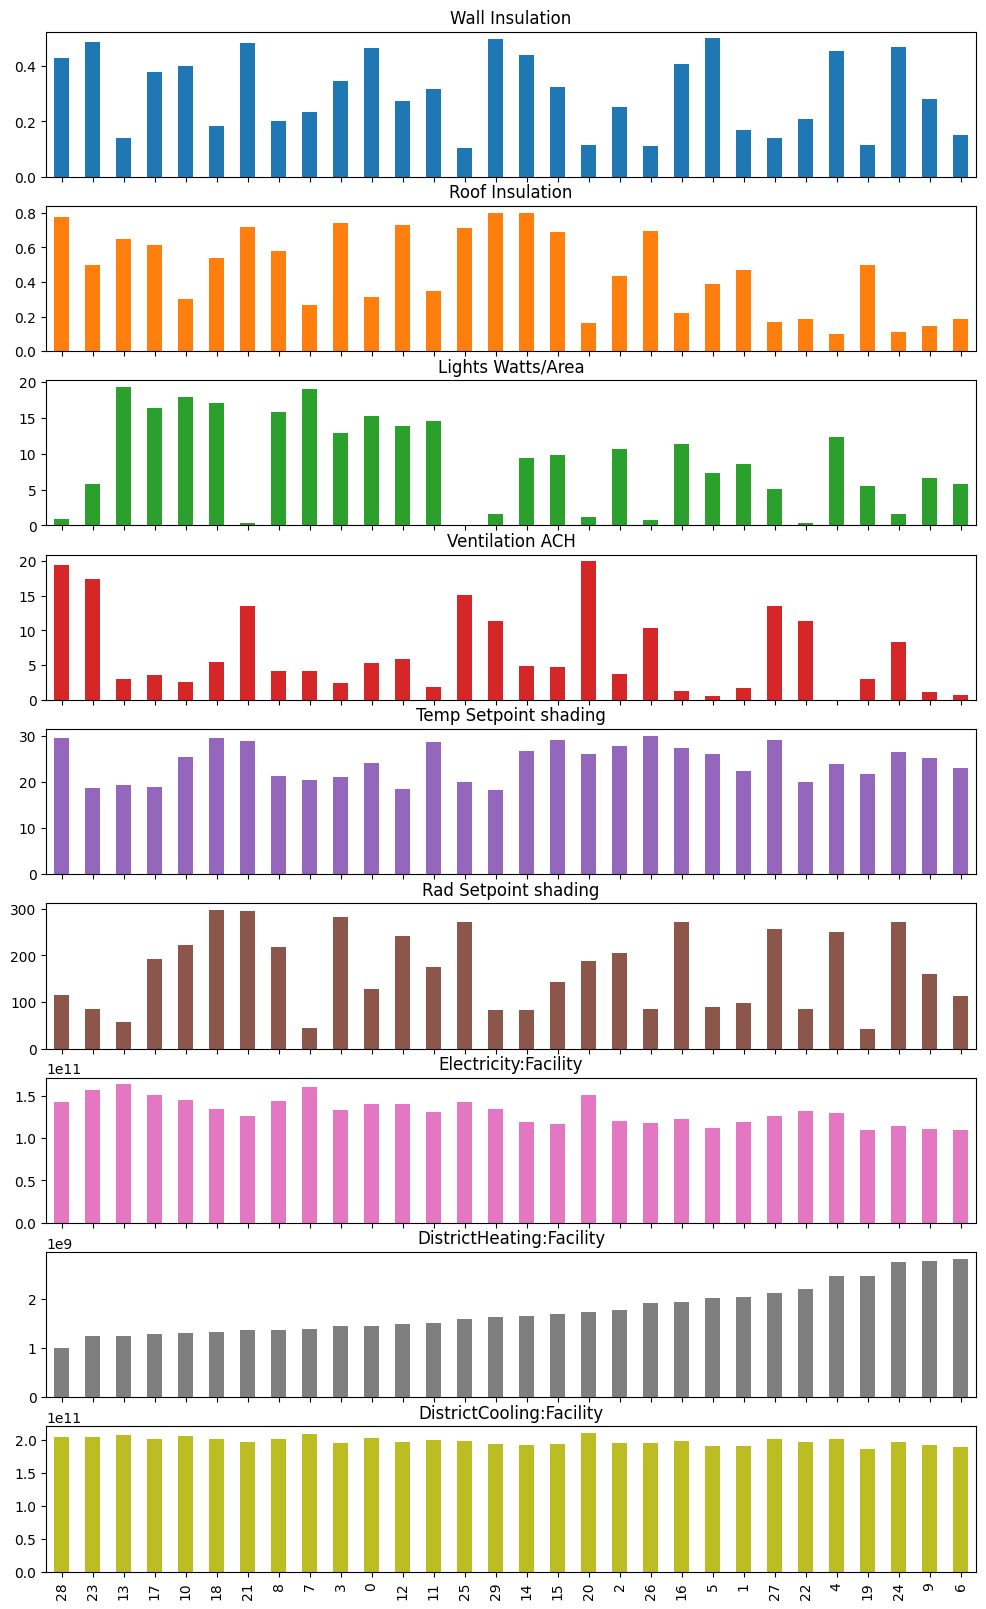

In [28]:
samples_original_df = samples_original_df.sort_values(by=output_cols[1])
ax=samples_original_df.plot.bar(subplots=True,legend=None, figsize=(12,20))

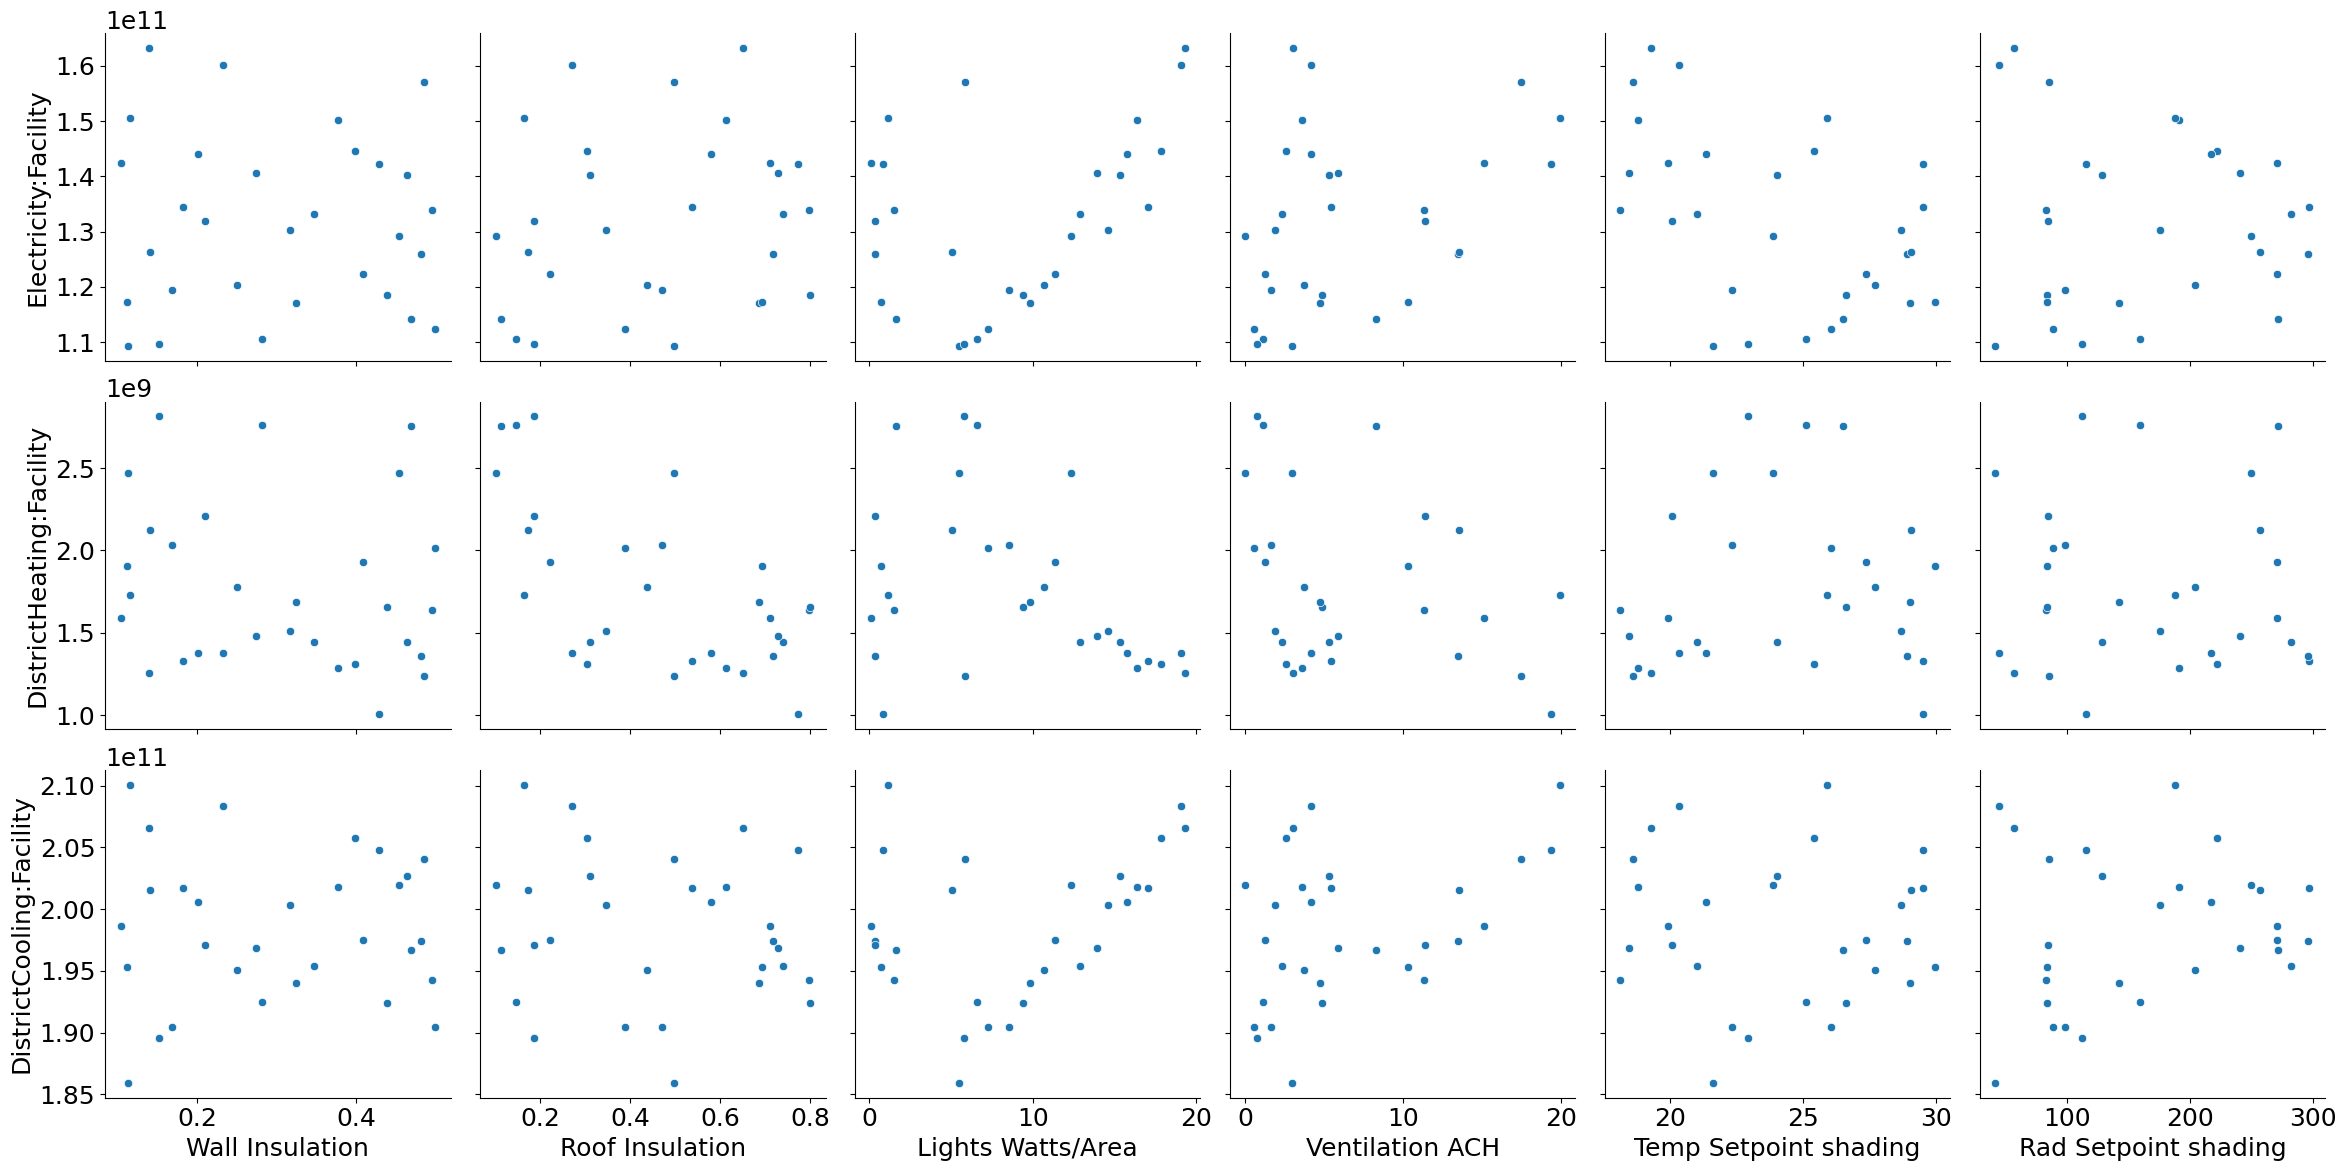

In [29]:
plt.rcParams.update({'font.size': 18})
_=pairplot(samples_original_df,x_vars=input_cols, y_vars=objectives, kind="scatter",height=4)

In [30]:
corr=samples_original_df.corr()
corr

,Wall Insulation,Roof Insulation,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
Wall Insulation,1.000000,0.069421,0.022336,-0.037173,0.064613,0.095589,-0.025121,-0.168927,0.021825
Roof Insulation,0.069421,1.000000,-0.023263,0.199950,-0.138192,-0.095337,0.171029,-0.615674,-0.143894
Lights Watts/Area,0.022336,-0.023263,1.000000,-0.652044,-0.178622,0.064710,0.393449,-0.376872,0.320027
Ventilation ACH,-0.037173,0.199950,-0.652044,1.000000,0.064811,0.029301,0.344891,-0.299259,0.397327
Temp Setpoint shading,0.064613,-0.138192,-0.178622,0.064811,1.000000,0.276382,-0.472003,0.093671,-0.034898
Rad Setpoint shading,0.095589,-0.095337,0.064710,0.029301,0.276382,1.000000,-0.029812,-0.044429,0.168560
Electricity:Facility,-0.025121,0.171029,0.393449,0.344891,-0.472003,-0.029812,1.000000,-0.735957,0.854216
DistrictHeating:Facility,-0.168927,-0.615674,-0.376872,-0.299259,0.093671,-0.044429,-0.735957,1.000000,-0.580711
DistrictCooling:Facility,0.021825,-0.143894,0.320027,0.397327,-0.034898,0.168560,0.854216,-0.580711,1.000000


In [31]:
corr.drop(objectives, axis = 1, inplace = True)
corr.drop(['Roof Insulation','Wall Insulation', 'Lights Watts/Area','Ventilation ACH','Temp Setpoint shading', 'Rad Setpoint shading'], axis = 0 ,inplace = True)
corr

,Wall Insulation,Roof Insulation,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading
Electricity:Facility,-0.025121,0.171029,0.393449,0.344891,-0.472003,-0.029812
DistrictHeating:Facility,-0.168927,-0.615674,-0.376872,-0.299259,0.093671,-0.044429
DistrictCooling:Facility,0.021825,-0.143894,0.320027,0.397327,-0.034898,0.168560


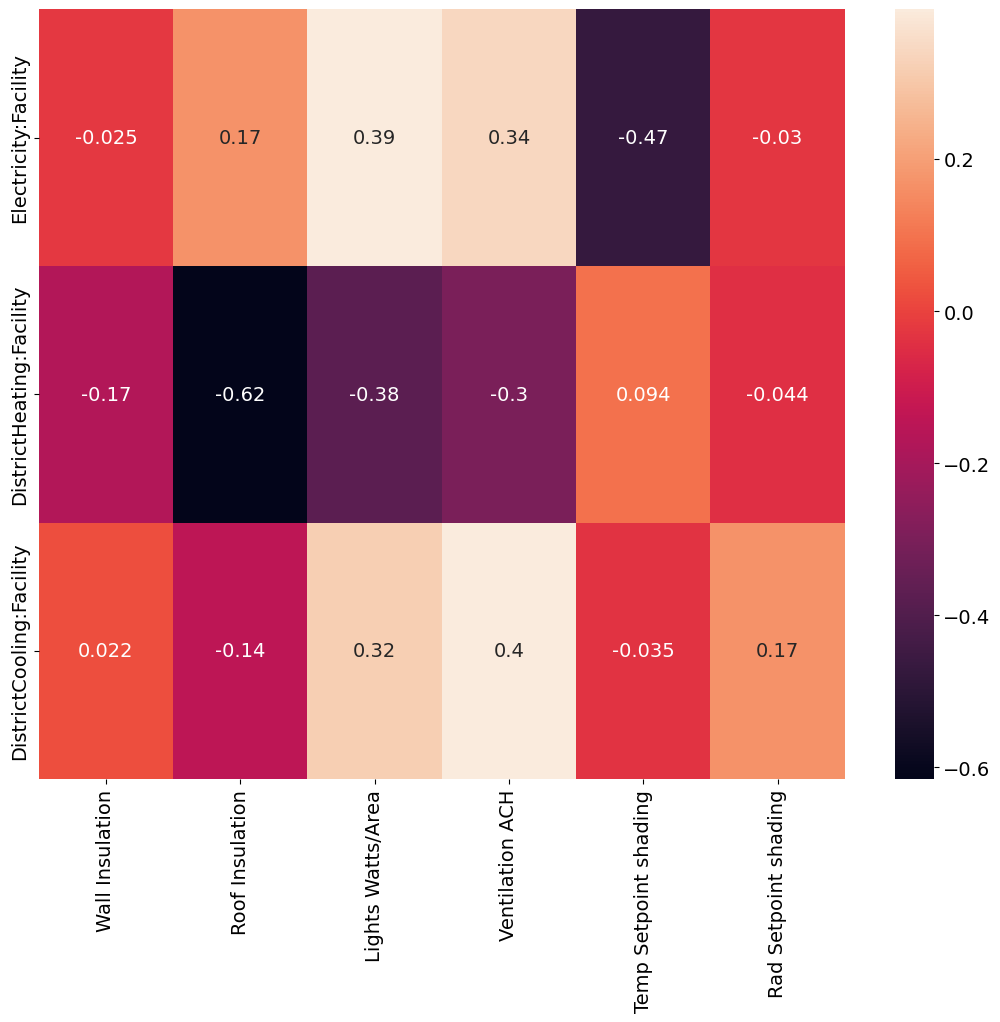

In [32]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize = (13,10))
_ = heatmap(corr,annot=True)

In [33]:
train_in, test_in, train_out, test_out = train_test_split(
    inputs_original_df, outputs_original_df, test_size=0.2
)

In [38]:
#second scaling we turn again the original samples in to scaled dataset to train and test surrogate models

scaler = StandardScaler()
train_in_scale = scaler.fit_transform(X=train_in)
test_in_scale = scaler.fit_transform(X=test_in)

scaler_out = StandardScaler()
train_out_scale = scaler_out.fit_transform(X=train_out)
test_out_scale = scaler_out.fit_transform(X=test_out)

In [39]:
hyperparameters = {
    "kernel": [
        None,
        1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
        1.0 * RationalQuadratic(length_scale=1.0, alpha=0.5),
        # ConstantKernel(0.1, (0.01, 10.0))*(DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0))**2),
        1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
    ]
}

folds = 3

gp = GaussianProcessRegressor(normalize_y=True)

clf = GridSearchCV(gp, hyperparameters, cv=folds)

clf.fit(train_in_scale, train_out_scale)

best_gp = clf.best_estimator_ 

prediction_gp = scaler_out.inverse_transform(best_gp.predict(test_in_scale))

In [40]:
hyperparameters = {
    "hidden_layer_sizes": (
        (len(parameters) * 16,),
        (len(parameters) * 16, len(parameters) * 16),
    ),
    "alpha": [1, 10, 10 ** 3],
}

neural_net = MLPRegressor(max_iter=1000, early_stopping=False)
folds = 3

clf = GridSearchCV(neural_net, hyperparameters, cv=folds)
clf.fit(train_in_scale, train_out_scale)

nn_model = clf.best_estimator_

prediction_nn = scaler_out.inverse_transform(nn_model.predict(test_in_scale))

In [37]:
def build_model():
    model = keras.Sequential(
        [
            layers.Input(shape=(train_in_scale.shape[1], )),
            layers.Dense(32, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(3),
        ]
    )

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss="mse", optimizer=optimizer, metrics=["mae", "mse"])
    return model

tf_model = build_model()

tf_model.summary()

EPOCHS = 1000

history = tf_model.fit(
    train_in_scale,
    train_out_scale,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=0,
)

prediction_tf = scaler_out.inverse_transform(tf_model.predict(test_in_scale))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,515 (17.64 KB)

 Trainable params: 4,515 (17.64 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


In [41]:
mse = mean_squared_error(prediction_gp,
                         test_out.values,
                         multioutput='raw_values')

# 2) RMSE
rmse = np.sqrt(mse)

mean_vals = test_out.mean().values
rmse_pct = rmse / mean_vals * 100


print("GP:")
print("RMSE:", rmse)
print("RMSE %:", rmse_pct)

GP:
RMSE: [8.98334038e+09 9.53835438e+07 3.74150385e+09]
RMSE %: [6.75406887 5.99519775 1.87871088]


In [42]:
mse_nn = mean_squared_error(
    prediction_nn,
    test_out.values,
    multioutput='raw_values'
)

# 2) RMSE
rmse_nn = np.sqrt(mse_nn)

mean_vals = test_out.mean().values
rmse_pct_nn = rmse_nn / mean_vals * 100

print("NN:")
print("RMSE NN:", rmse_nn)
print("RMSE % NN:", rmse_pct_nn)

NN:
RMSE NN: [8.83940842e+09 1.01699331e+08 3.61642292e+09]
RMSE % NN: [6.64585451 6.39216762 1.81590434]


In [43]:
mse_tf = mean_squared_error(
    prediction_tf,
    test_out.values,
    multioutput='raw_values'
)

# 2) RMSE
rmse_tf = np.sqrt(mse_tf)

mean_vals = test_out.mean().values
rmse_pct_tf = rmse_tf / mean_vals * 100


print("TF:")
print("RMSE TensorFlow:", rmse_tf)
print("RMSE % TensorFlow:", rmse_pct_tf)

TF:
RMSE TensorFlow: [8.74354340e+09 1.14231300e+08 4.32500055e+09]
RMSE % TensorFlow: [6.57377899 7.17984682 2.17170045]


In [44]:
parameters = insulation_param + [lights_param]  + ventilationAchParam + setpointParams

objectives = ['Electricity:Facility','DistrictHeating:Facility','DistrictCooling:Facility']

In [45]:
def evaluation_func(ind, scaler=scaler):
    ind = scaler.transform(X=[ind])
    return (scaler_out.inverse_transform(best_gp.predict(ind))[0]).tolist()

evaluator = EvaluatorGeneric(evaluation_func, problem)

srinputs = sampling.dist_sampler(sampling.lhs, problem, 500)
sroutputs = evaluator.df_apply(srinputs)
srresults = srinputs.join(sroutputs)
srresults.head()

Executing:   0%|          | 0/500 [00:00<?, ?row/s]

,Wall Insulation,Roof Insulation,Ventilation ACH,Lights Watts/Area,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
0,0.170341,0.562792,3.447492,16.741185,27.064551,224.168762,1.320475e+11,1.556028e+09,1.995539e+11
1,0.448562,0.292101,2.416423,10.937987,26.362615,90.265918,1.290623e+11,1.665218e+09,1.973758e+11
2,0.345719,0.597253,1.451339,12.766727,28.710632,255.562217,1.238567e+11,1.590292e+09,1.958551e+11
3,0.123124,0.183924,5.518051,14.806733,29.878569,168.826382,1.295597e+11,1.739486e+09,2.017150e+11
4,0.360535,0.160530,1.915424,18.673454,19.295856,252.187926,1.434678e+11,1.752728e+09,2.057182e+11


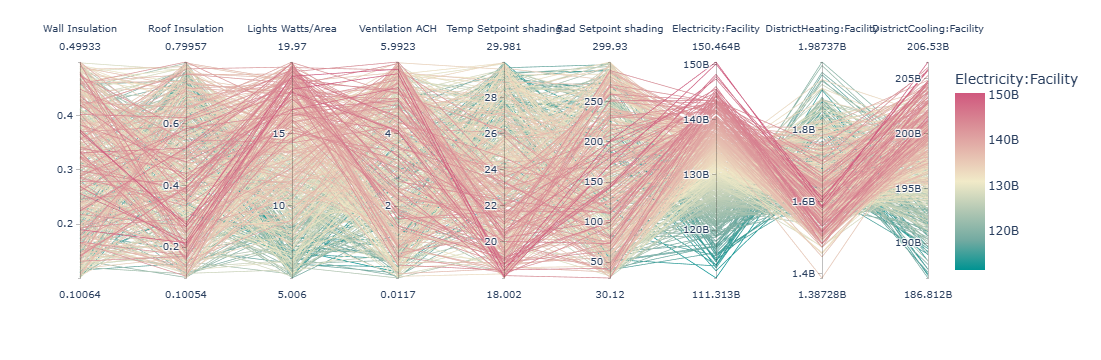

In [46]:
import plotly
plotly.offline.init_notebook_mode(connected=True)

features = input_cols
import plotly.express as px
fig = px.parallel_coordinates(srresults,color="Electricity:Facility", dimensions=features+objectives,
                             color_continuous_scale=px.colors.diverging.Tealrose)
fig.show()

In [47]:
from platypus import Problem, Real, NSGAII
import numpy as np

# 1) Número de variables y de objetivos
d = len(features)
m = len(objectives)

# 2) Monta el problema Platypus “a mano”
plat_prob = Problem(d, m)
plat_prob.types[:] = [
    Real(param.value_descriptor.min, param.value_descriptor.max)
    for param in parameters
]
plat_prob.function = lambda xs: tuple(evaluation_func(xs))

# 3) Corre NSGA-II
algo = NSGAII(plat_prob, population_size=10000)
algo.run(5000)

# 4) Saca tu frente Pareto
pareto = algo.result
objectives_array = np.array([sol.objectives for sol in pareto])

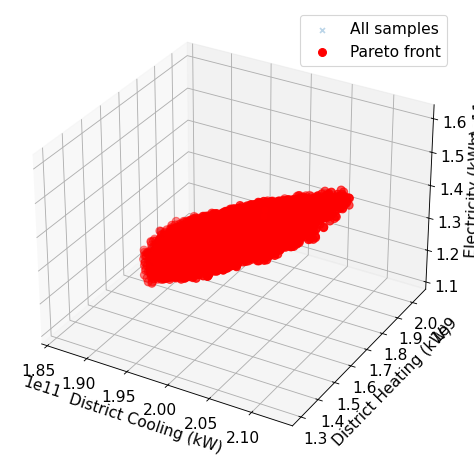

In [48]:
pareto_sols = algo.result
X_pareto = np.array([sol.variables  for sol in pareto_sols])
Y_pareto = np.array([sol.objectives for sol in pareto_sols])

# 2) Montar DataFrame de Pareto con las mismas columnas que srresults
opt_df = pd.DataFrame(
    np.hstack([X_pareto, Y_pareto]),
    columns=features + objectives
)

# 3) Graficar todo el muestreo inicial y el frente Pareto en 3D
fig = plt.figure(figsize=(8, 6), dpi=80)
ax  = fig.add_subplot(111, projection='3d')

# Muestreo inicial en azul con cruces
ax.scatter(
    srresults["DistrictCooling:Facility"],
    srresults["DistrictHeating:Facility"],
    srresults["Electricity:Facility"],
    marker='x', alpha=0.3, label='All samples'
)

# Frontera de Pareto en rojo con círculos
ax.scatter(
    opt_df["DistrictCooling:Facility"],
    opt_df["DistrictHeating:Facility"],
    opt_df["Electricity:Facility"],
    c='r', marker='o', s=50, label='Pareto front'
)

ax.set_xlabel("District Cooling (kW)")
ax.set_ylabel("District Heating (kW)")
ax.set_zlabel("Electricity (kWh)")
ax.legend()
plt.tight_layout()
plt.show()

In [49]:
opt_df

,Wall Insulation,Roof Insulation,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
0,0.495372,0.421065,12.046649,1.678974,25.022989,278.720775,1.328589e+11,1.637876e+09,2.011449e+11
1,0.339108,0.266077,12.288259,3.068960,28.288175,98.470672,1.292132e+11,1.648236e+09,1.987117e+11
2,0.479432,0.210993,13.194939,3.468499,20.811185,180.921032,1.409620e+11,1.685526e+09,2.046701e+11
3,0.197556,0.456767,15.959579,0.900108,26.874722,109.309645,1.362118e+11,1.567322e+09,2.007455e+11
4,0.303093,0.460968,9.669275,3.955159,19.705292,85.796001,1.366309e+11,1.624168e+09,1.973466e+11
...,...,...,...,...,...,...,...,...,...
9995,0.261867,0.249843,5.876833,5.705868,19.947907,288.822206,1.309097e+11,1.909304e+09,1.999462e+11
9996,0.239099,0.476523,18.983068,2.865028,22.672495,264.023086,1.510274e+11,1.443370e+09,2.086087e+11
9997,0.367541,0.175033,16.259903,4.814967,18.079986,149.882260,1.506016e+11,1.619165e+09,2.082743e+11
9998,0.158345,0.103867,6.725178,2.877284,23.874124,40.594521,1.251397e+11,1.858316e+09,1.950366e+11


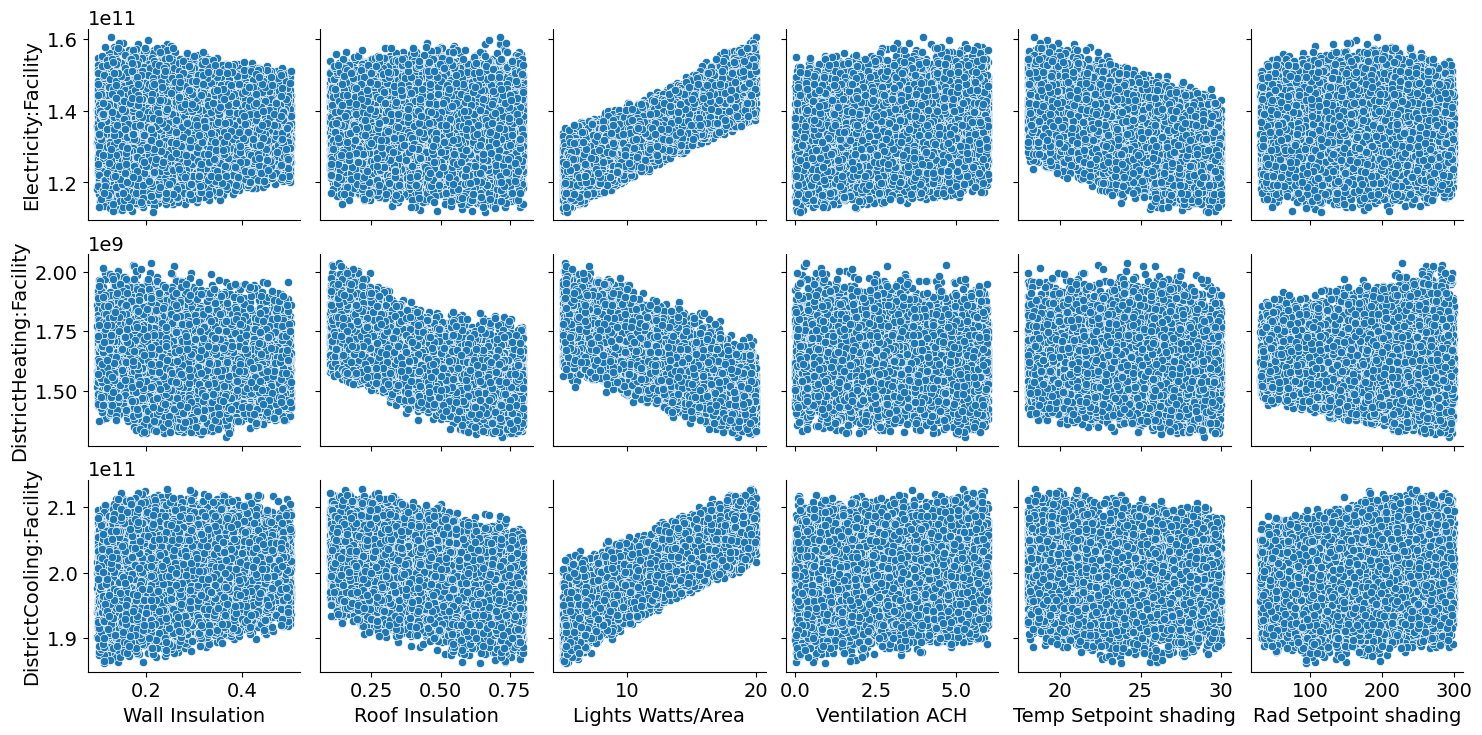

In [50]:
_=pairplot(opt_df,x_vars=input_cols, y_vars=objectives, kind="scatter")

In [51]:
pareto_sols = algo.result  # o NSGAII(...) según tu opción B
X_pareto = np.array([sol.variables  for sol in pareto_sols])
Y_pareto = np.array([sol.objectives for sol in pareto_sols])
opt_df = pd.DataFrame(np.hstack([X_pareto, Y_pareto]), columns=features + objectives)

In [52]:
corr=opt_df.corr()

corr.drop(objectives, axis = 1, inplace = True)
corr.drop(features, axis = 0 ,inplace = True)
corr

,Wall Insulation,Roof Insulation,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading
Electricity:Facility,0.042793,-0.047418,0.841716,0.135586,-0.479688,0.024503
DistrictHeating:Facility,-0.183602,-0.610076,-0.686790,-0.126308,-0.066446,0.006804
DistrictCooling:Facility,0.092780,-0.374354,0.847368,0.122967,-0.189061,0.183908


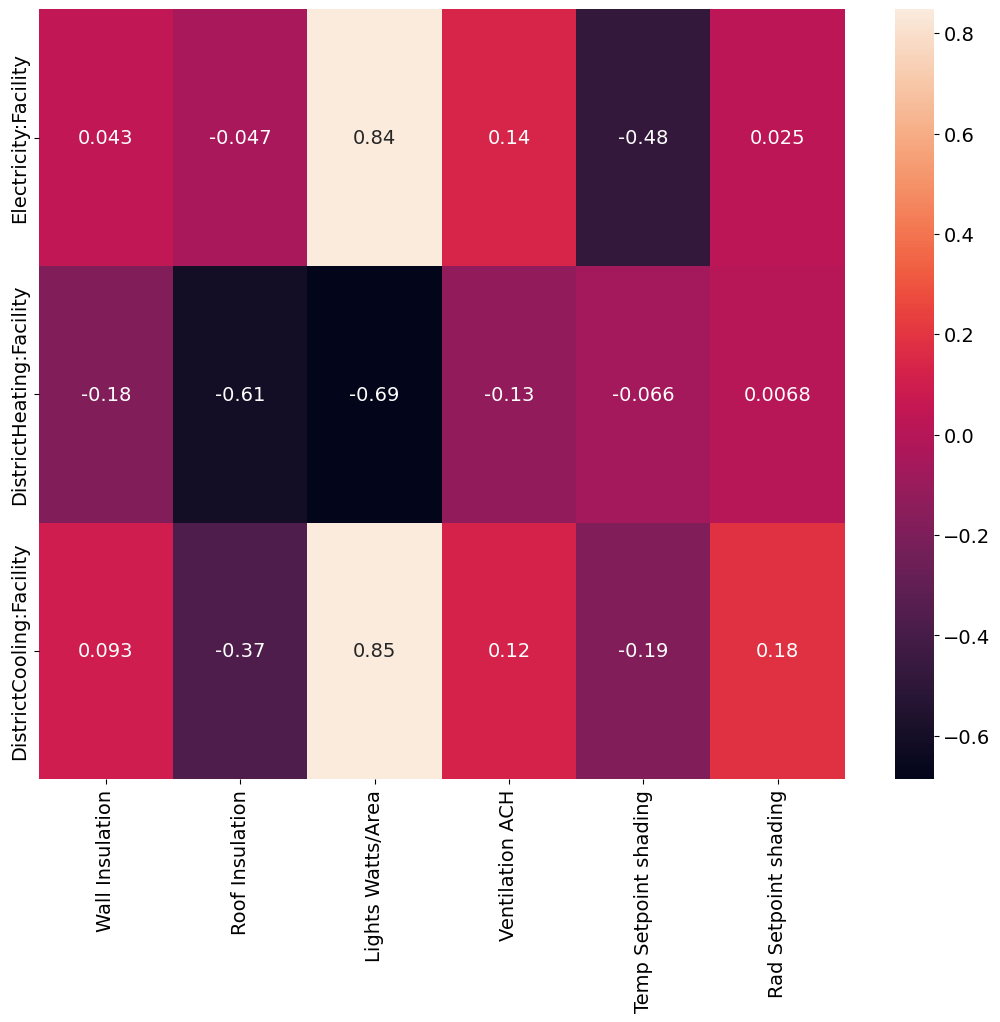

In [53]:
plt.figure(figsize = (13,10))
_ = heatmap(corr,annot=True)

In [54]:
opt_df['Total'] = opt_df['Electricity:Facility'] + opt_df['DistrictHeating:Facility'] + opt_df['DistrictCooling:Facility']
opt_df['Dist'] = opt_df.apply(lambda row : np.sqrt(pow(row["DistrictCooling:Facility"],2) + pow(row["DistrictHeating:Facility"],2) + pow(row["Electricity:Facility"],2)),axis=1)

opt_df[opt_df.Dist == opt_df.Dist.min()]

,Wall Insulation,Roof Insulation,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility,Total,Dist
1264,0.141593,0.577133,5.436801,0.03564,25.612158,106.404894,1.127300e+11,1.819032e+09,1.864414e+11,3.009903e+11,2.178801e+11


In [55]:
optimal_params=opt_df.loc[opt_df.Dist == opt_df.Dist.min(),features].to_dict('records')[0]
optimal_params

{'Wall Insulation': 0.14159329297723866,
 'Roof Insulation': 0.5771326926924744,
 'Lights Watts/Area': 5.436801261483671,
 'Ventilation ACH': 0.03564041209701285,
 'Temp Setpoint shading': 25.612158372223774,
 'Rad Setpoint shading': 106.40489414851535}